In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# If running in Colab, we need to make the project available.
import os
if os.getenv("COLAB_RELEASE_TAG"):
    !rm -fr knowledge-graphs-langchain
    !git clone https://github.com/datastax-labs/knowledge-graphs-langchain.git
    %pip install poetry python-dotenv
    !cd knowledge-graphs-langchain && poetry install

In [14]:
# Load environment variables from `.env`.
# See `env.template` for an example of what you should have there.
import dotenv
dotenv.load_dotenv()

True

In [17]:
# Initialize cassandra connection (to Astra, in this case).
import cassio
cassio.init(auto=True)

In [18]:
# Create graph store.
from knowledge_graph.cassandra_graph_store import CassandraGraphStore
graph_store = CassandraGraphStore()

# Extracting Knowledge Graph

## Using LLMGraphTansformer

In [6]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_openai import ChatOpenAI

# Prompt used by LLMGraphTransformer is tuned for Gpt4.
llm = ChatOpenAI(temperature=0, model_name="gpt-4")

llm_transformer = LLMGraphTransformer(llm=llm)

In [7]:
from langchain_core.documents import Document

text = """
Marie Curie, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.
She was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields.
Her husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes.
She was, in 1906, the first woman to become a professor at the University of Paris.
"""
documents = [Document(page_content=text)]
graph_documents = llm_transformer.convert_to_graph_documents(documents)
print(f"Nodes:{graph_documents[0].nodes}")
print(f"Relationships:{graph_documents[0].relationships}")

Nodes:[Node(id='Marie Curie', type='Person'), Node(id='Pierre Curie', type='Person'), Node(id='Nobel Prize', type='Award'), Node(id='University Of Paris', type='Organization'), Node(id='Polish', type='Nationality'), Node(id='French', type='Nationality'), Node(id='Physicist', type='Profession'), Node(id='Chemist', type='Profession'), Node(id='Radioactivity', type='Scientific field'), Node(id='Professor', type='Profession')]
Relationships:[Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='Polish', type='Nationality'), type='HAS_NATIONALITY'), Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='French', type='Nationality'), type='HAS_NATIONALITY'), Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='Physicist', type='Profession'), type='HAS_PROFESSION'), Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='Chemist', type='Profession'), type='HAS_PROFESSION'), Relationship(source=Node(id='Marie Cur

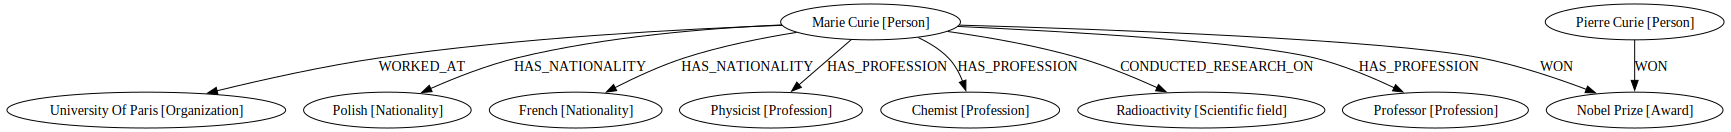

In [8]:
from knowledge_graph.render import render_graph_document
render_graph_document(graph_documents[0])

In [ ]:
# Save the extracted graph documents to the Cassandra Graph Store.
graph_store.add_graph_documents(graph_documents)

### Optional: Predefine entities / relationships

The below configures the `LLMGraphTransformer` with specific kinds of nodes and relationships it is allowed to extract.
This is useful for constraining what will be extracted.

```python
llm_transformer_filtered = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=["Person", "Country", "Organization"],
    allowed_relationships=["NATIONALITY", "LOCATED_IN", "WORKED_AT", "SPOUSE"],
)
graph_documents_filtered = llm_transformer_filtered.convert_to_graph_documents(
    documents
)
print(f"Nodes:{graph_documents_filtered[0].nodes}")
print(f"Relationships:{graph_documents_filtered[0].relationships}")
```

# Querying

In [9]:
from knowledge_graph.traverse import Node

graph_store.as_runnable(steps=2).invoke(Node("Marie Curie", "Person"))

{Marie Curie(Person) -> Chemist(Profession): HAS_PROFESSION,
 Marie Curie(Person) -> French(Nationality): HAS_NATIONALITY,
 Marie Curie(Person) -> Nobel Prize(Award): WON,
 Marie Curie(Person) -> Physicist(Profession): HAS_PROFESSION,
 Marie Curie(Person) -> Pierre Curie(Person): MARRIED_TO,
 Marie Curie(Person) -> Polish(Nationality): HAS_NATIONALITY,
 Marie Curie(Person) -> Professor(Profession): HAS_PROFESSION,
 Marie Curie(Person) -> Radioactivity(Scientific concept): RESEARCHED,
 Marie Curie(Person) -> University Of Paris(Organization): WORKED_AT,
 Pierre Curie(Person) -> Nobel Prize(Award): WON}

In [20]:
from operator import itemgetter
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from knowledge_graph import extract_entities
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name = "gpt-4")

def _combine_relations(relations):
    return "\n".join(map(repr, relations))

ANSWER_PROMPT = (
    "The original question is given below."
    "This question has been used to retrieve information from a knowledge graph."
    "The matching triples are shown below."
    "Use the information in the triples to answer the original question.\n\n"
    "Original Question: {question}\n\n"
    "Knowledge Graph Triples:\n{context}\n\n"
    "Response:"
)

chain = (
    { "question": RunnablePassthrough() }
    | RunnablePassthrough.assign(entities = extract_entities(llm))
    | RunnablePassthrough.assign(triples = itemgetter("entities") | graph_store.as_runnable())
    | RunnablePassthrough.assign(context = itemgetter("triples") | RunnableLambda(_combine_relations))
    | ChatPromptTemplate.from_messages([ANSWER_PROMPT])
    | llm
)

In [23]:
# Example showing extracted entities (nodes)
extract_entities(llm).invoke({ "question": "Who is Marie Curie?"})

[Marie Curie(Person)]

In [24]:
chain.invoke("Who is Marie Curie?")

AIMessage(content='Marie Curie is a Polish and French chemist, physicist, and professor who researched radioactivity. She was married to Pierre Curie and has worked at the University of Paris. She is also a recipient of the Nobel Prize.', response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 213, 'total_tokens': 260}, 'model_name': 'gpt-4', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-bbd27d14-9d6f-4f63-974a-602225a55ced-0')